In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
sns.set_palette('colorblind')
from matplotlib.pyplot import tight_layout
# ##SETTING PARAMS FOR MATPLOTLIB FIGURES
plt.rcParams.update({"figure.figsize": (6, 6),
                 "axes.facecolor": "white",
                 "axes.edgecolor": "black"})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('colorblind'))
##set font size
font = {'family': 'sans-serif',
       'weight': 'normal',
       'size': 10}
plt.rc('font', **font)
# ##PANDAS PLOTTING
pd.plotting.register_matplotlib_converters()

### Step 1: save environment file

In [2]:
!conda env export > time_series_environment.yml

### Step 2: Load combined dataset

In [3]:
merged_ihfd_met= "/home/paulharford/college/project/project_data/processed/WEATHERED_merged_v2.csv"
full_path_merged = os.path.abspath(merged_ihfd_met)

In [4]:
merged_reg = pd.read_csv(full_path_merged)

In [5]:
merged_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97119 entries, 0 to 97118
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   region                    97119 non-null  object 
 1   date                      97119 non-null  object 
 2   age_group                 97119 non-null  object 
 3   gender                    97119 non-null  object 
 4   hip_fracture_count        97119 non-null  float64
 5   weather_event             97119 non-null  float64
 6   warning_phenomenon        97119 non-null  object 
 7   warning_severity          97119 non-null  object 
 8   warning_severity_numeric  97119 non-null  float64
 9   counties_in_region        97119 non-null  int64  
 10  county_weight             97119 non-null  float64
 11  female                    97119 non-null  float64
 12  male                      97119 non-null  float64
 13  total                     97119 non-null  float64
 14  popula

In [6]:
merged_reg.head()

,region,date,age_group,gender,hip_fracture_count,weather_event,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,...,red_warning_lag,cold_weather,wind_weather,precipitation,heat_weather,no_adverse_weather,cold_lag,wind_lag,precip_lag,heat_lag
0,HSE Dublin and Midlands,2014-01-02,65-69,Female,1.0,1.0,Wind,Yellow,1.0,7,...,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0
1,HSE Dublin and Midlands,2014-01-03,60-64,Female,0.0,1.0,Wind,Yellow,1.0,7,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0
2,HSE Dublin and Midlands,2014-01-03,65-69,Female,0.0,1.0,Wind,Yellow,1.0,7,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0
3,HSE Dublin and Midlands,2014-01-03,70-74,Female,0.0,1.0,Wind,Yellow,1.0,7,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0
4,HSE Dublin and Midlands,2014-01-03,75-79,Female,0.0,1.0,Wind,Yellow,1.0,7,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0


### Step 3: Remove lag features

In [7]:
# List of columns to drop
columns_to_drop = ['cold_lag', 'wind_lag', 'precip_lag', 'heat_lag','red_warning_lag','orange_warning_lag','no_adverse_weather']

# Drop the columns
merged_reg = merged_reg.drop(columns=columns_to_drop)

# Verify the columns were dropped
print(f"Shape after dropping columns: {merged_reg.shape}")

Shape after dropping columns: (97119, 29)


### Step 4: Separate into training and unseen datasets

In [8]:
print("Merged Date Range:")
print(f"Start date: {merged_reg['date'].min()}")
print(f"End date: {merged_reg['date'].max()}")

Merged Date Range:
Start date: 2014-01-02
End date: 2023-12-30


In [9]:
df_merged_train = merged_reg[
    (merged_reg['date'] >= '2014-01-01') & 
    (merged_reg['date'] <= '2022-12-31')
]

In [10]:
df_merged_unseen = merged_reg[
    (merged_reg['date'] >= '2023-01-01') & 
    (merged_reg['date'] <= '2023-12-31')
]

### Step 4.1: Update date format 

In [11]:
df_merged_train = df_merged_train.copy()
df_merged_unseen = df_merged_unseen.copy()

df_merged_train['date'] = pd.to_datetime(df_merged_train['date'])
df_merged_unseen['date'] = pd.to_datetime(df_merged_unseen['date'])

### Step 4.2: Add features

In [12]:
df_merged_train['has_weather_event'] = (df_merged_train['weather_event'] > 0).astype(int)
df_merged_train['hip_weather_interaction'] = df_merged_train['hip_fracture_count'] * df_merged_train['has_weather_event']
df_merged_unseen['has_weather_event'] = (df_merged_unseen['weather_event'] > 0).astype(int)
df_merged_unseen['hip_weather_interaction'] = df_merged_unseen['hip_fracture_count'] * df_merged_unseen['has_weather_event']

### Step 5: functions for creating and aggregating data for prophet

In [13]:
# Create targeted interaction features
def create_enhanced_features(df):
    """
    Create enhanced features for time series data
    
    Parameters:
    -----------
    df : DataFrame
        Time series data with a date column        
    Returns:
    --------
    DataFrame
        DataFrame with added enhanced features
    """
    # Copy the dataframe
    enhanced_df = df.copy()
    
    # Define age groups
    age_groups = {
        'elderly': ['75-79', '80-84', '85 years and over'],
        'senior': ['60-64', '65-69', '70-74'],
        'middle_aged': ['45-49', '50-54', '55-59'],
        'adult': ['25-29', '30-34', '35-39', '40-44']
    }
    
    # columns for each age group
    for group_name, age_list in age_groups.items():
        enhanced_df[f'is_{group_name}'] = enhanced_df['age_group'].isin(age_list).astype(int)
    
    # Create gender binary columns if not already present
    if 'gender' in enhanced_df.columns:
        enhanced_df['is_male'] = (enhanced_df['gender'] == 'Male').astype(int)
        enhanced_df['is_female'] = (enhanced_df['gender'] == 'Female').astype(int)
    
    # Create age-gender combination features
    # These will be your regressors
    for group_name in age_groups.keys():
        # Age group + gender combinations
        enhanced_df[f'{group_name}_male'] = enhanced_df[f'is_{group_name}'] * enhanced_df['is_male']
        enhanced_df[f'{group_name}_female'] = enhanced_df[f'is_{group_name}'] * enhanced_df['is_female']
        
        # Age group + gender + weather interactions
        enhanced_df[f'{group_name}_male_weather'] = (
            enhanced_df[f'{group_name}_male'] * enhanced_df['has_weather_event']
        )
        enhanced_df[f'{group_name}_female_weather'] = (
            enhanced_df[f'{group_name}_female'] * enhanced_df['has_weather_event']
        )
        
        # Age group + gender + cold weather (high risk combination)
        enhanced_df[f'{group_name}_female_cold'] = (
            enhanced_df[f'{group_name}_female'] * enhanced_df['cold_weather']
        )
    
    if 'is_female' in enhanced_df.columns and 'is_male' in enhanced_df.columns:
        total = enhanced_df['is_female'] + enhanced_df['is_male']
        enhanced_df['female_ratio'] = enhanced_df['is_female'] / total
        enhanced_df['male_ratio'] = enhanced_df['is_male'] / total
    
    
    # Create seasonal interaction features
    enhanced_df['winter_weather'] = enhanced_df['is_winter'] * enhanced_df['has_weather_event']
    enhanced_df['summer_weather'] = enhanced_df['is_summer'] * enhanced_df['has_weather_event']
    enhanced_df['spring_weather'] = enhanced_df['is_spring'] * enhanced_df['has_weather_event']
    enhanced_df['autumn_weather'] = enhanced_df['is_autumn'] * enhanced_df['has_weather_event']
    
    # Create thresholds for extreme weather events (if warning_severity_numeric exists)
    if 'warning_severity_numeric' in enhanced_df.columns:
        enhanced_df['elderly_female_hr_orange'] = (enhanced_df['warning_severity_numeric']== 2).astype(int) * enhanced_df['elderly_female']
        enhanced_df['elderly_female_hr_red'] = (enhanced_df['warning_severity_numeric'] == 3).astype(int) * enhanced_df['elderly_female']
    
    return enhanced_df

In [14]:
def analyze_prophet_components(model, forecast):
    """Analyze how different components contribute to the Prophet forecast"""
    
    # Extract components
    components = ['trend', 'yearly']
    
    # Plot the component contributions
    plt.figure(figsize=(14, 10))
    
    # Plot each component
    for i, component in enumerate(components, 1):
        if component in forecast.columns:
            plt.subplot(len(components) + 1, 1, i)
            plt.plot(forecast['ds'], forecast[component])
            plt.title(f'{component.capitalize()} Component')
            plt.grid(True, alpha=0.3)
    
    # Plot the final prediction
    plt.subplot(len(components) + 1, 1, len(components) + 1)
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    
    # If we have actual values, plot them too
    if 'y' in forecast.columns:
        plt.plot(forecast['ds'], forecast['y'], 'k.', label='Actual')
    
    plt.title('Overall Forecast')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate contribution percentages
    if len(components) > 0:
        component_ranges = {}
        for component in components:
            if component in forecast.columns:
                component_range = forecast[component].max() - forecast[component].min()
                component_ranges[component] = component_range
        
        total_range = sum(component_ranges.values())
        
        print("\nComponent Contribution Analysis:")
        for component, range_val in component_ranges.items():
            contribution = (range_val / total_range) * 100 if total_range > 0 else 0
            print(f"{component.capitalize()}: {contribution:.1f}% of forecast variation")

In [15]:
def create_monthly_data_with_features(df, target_col='hip_fracture_count'):
    """Create monthly data with lag features and enhanced interactions"""
    
    # Then add enhanced features
    enhanced_df = create_enhanced_features(df)
    
    # Define aggregation functions for different feature types
    agg_functions = {
        'hip_fracture_count': 'sum',
        'has_weather_event': 'mean',  # Percentage of days with weather events
        'cold_weather': 'mean',       # Percentage of days with cold weather
        'heat_weather': 'mean',
        'wind_weather': 'mean',
        'precipitation': 'mean',
        'yellow_warning': 'mean',     # Percentage of days with yellow warnings
        'orange_warning': 'mean',     # Percentage of days with orange warnings
        'red_warning': 'mean',        # Percentage of days with red warnings
    }
        
    # Add enhanced features aggregation
    enhanced_aggs = {
        'hip_weather_interaction': 'sum',
        'female_ratio': 'mean',
        'male_ratio': 'mean',
        'summer_weather': 'mean',
        'winter_weather': 'mean',
        'spring_weather': 'mean',
        'autumn_weather': 'mean',
        #'cold_weather_intensity': 'mean'
        'elderly_female_hr_orange': 'sum',
        'elderly_female_hr_red': 'sum',

    }
    agg_functions.update(enhanced_aggs)
    
    # Only include columns that exist in the dataframe
    agg_columns = {col: func for col, func in agg_functions.items() 
                  if col in enhanced_df.columns}
    
    # Aggregate to monthly level
    monthly_df = enhanced_df.groupby(pd.Grouper(key='date', freq='M')).agg(agg_columns).reset_index()
    
    return monthly_df

In [16]:
# Prepare the training data
def prepare_prophet_training_data(training_df):
    """Prepare the training data for Prophet"""
    
    # Create monthly data 
    monthly_train = create_monthly_data_with_features(training_df)
    
    # Drop rows with 
    monthly_train_clean = monthly_train.dropna()
    
    print(f"Training data shape after creating features: {monthly_train.shape}")
    print(f"Training data shape after removing NaN values: {monthly_train_clean.shape}")
    monthly_train.head()
    
    return monthly_train_clean

### Step 5.1: functions for analysing and view statistics of model 

In [17]:
def calculate_perturbation_importance(model, test_data, features):
    """Calculate feature importance by perturbing each feature"""
    
    # Make baseline prediction
    baseline_forecast = model.predict(test_data)
    baseline_predictions = baseline_forecast['yhat'].values
    
    # Calculate impact of each feature
    feature_importance = {}
    
    for feature in features:
        if feature in test_data.columns:
            # Create a copy with this feature set to its mean
            modified_df = test_data.copy()
            feature_mean = modified_df[feature].mean()
            modified_df[feature] = feature_mean
            
            # Make predictions
            modified_forecast = model.predict(modified_df)
            modified_predictions = modified_forecast['yhat'].values
            
            # Calculate the impact
            impact = np.mean(np.abs(baseline_predictions - modified_predictions))
            feature_importance[feature] = impact
    
    # Create DataFrame and sort
    importance_df = pd.DataFrame({
        'Feature': list(feature_importance.keys()),
        'Importance': list(feature_importance.values())
    })
    
    # Add relative importance
    if len(importance_df) > 0 and importance_df['Importance'].sum() > 0:
        importance_df['Relative_Importance'] = (
            importance_df['Importance'] / importance_df['Importance'].sum() * 100
        )
        importance_df = importance_df.sort_values('Importance', ascending=False)
        
        # Visualize
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'], importance_df['Relative_Importance'])
        plt.xlabel('Relative Importance (%)')
        plt.ylabel('Feature')
        plt.title('Feature Importance by Perturbation')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No meaningful feature importance could be calculated")
    
    return importance_df

### Step 5.2: functions for training validating and prediction on unseen data

In [18]:
def train_prophet_with_features(monthly_train):
    """
    Train a Prophet model with lag features and enhanced interactions
    
    Parameters:
    -----------
    monthly_train : DataFrame
        Monthly aggregated data with features
        
    Returns:
    --------
    model : Prophet model
        Trained Prophet model
    regressors : list
        List of regressors used in the model
    """
    
    # Prepare data for Prophet
    prophet_df = monthly_train.rename(columns={'date': 'ds', 'hip_fracture_count': 'y'})
    
    # Define which features to use as regressors
    potential_regressors = [ 
        # Weather interactions
        'hip_weather_interaction',
        'cold_weather_intensity',

        
        # Basic weather
        'has_weather_event',
        'cold_weather',
        'heat_weather',
        'winter_weather',
        'summer_weather',
        'spring_weather',
        'autumn_weather',
        'wind_weather',
        'precipitation',
        
        # Demographics
        'female_ratio',
        'male_ratio',
        'elderly_female_hr_orange',
        'elderly_female_hr_red'

        
    ]
    
    # Only use regressors that exist in the dataframe
    regressors = [col for col in potential_regressors if col in prophet_df.columns]
    
    print(f"Using these regressors in Prophet model: {regressors}")
    
    # Initialize Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        n_changepoints=40, 
        changepoint_range=0.85, 
        changepoint_prior_scale=0.25,
        seasonality_prior_scale=7.5
    )
    
    # Add the regressors
    for regressor in regressors:
        model.add_regressor(regressor)
    
    # Fit the model
    model.fit(prophet_df)
    
    return model, regressors


def validate_prophet_model_with_monthly_splits(df_merged_train, n_splits=3, test_size_months=6):
    """
    Validate the Prophet model using monthly time-based splits
    
    Parameters:
    -----------
    df_merged_train : DataFrame
        The training dataset with date and target variable (hip_fracture_count)
    n_splits : int
        Number of splits for time series cross-validation
    test_size_months : int
        Size of each test set in months
        
    Returns:
    --------
    dict with evaluation metrics, trained models, and forecasts
    """
    
    # Sort the data by date
    df_sorted = df_merged_train.sort_values('date')
    
    # Extract month information
    df_sorted['month'] = df_sorted['date'].dt.to_period('M')
    
    # Get unique months in order
    unique_months = sorted(df_sorted['month'].unique())
    
    # Determine the total number of months available
    n_months = len(unique_months)
    print(f"Dataset contains {n_months} months of data")
    
    # Check if we have enough data for the requested splits
    total_required_months = n_splits * test_size_months
    if total_required_months > n_months:
        print(f"Warning: Not enough data for {n_splits} splits with {test_size_months} months each.")
        print(f"Reducing to {n_months // test_size_months} splits.")
        n_splits = max(1, n_months // test_size_months)
    
    # Calculate where to start the test sets
    test_start_indices = []
    for i in range(n_splits):
        test_start_idx = n_months - (i + 1) * test_size_months
        if test_start_idx < 0:
            break
        test_start_indices.append(test_start_idx)
    
    # Reverse so we go chronologically
    test_start_indices.reverse()
    
    # Initialize storage for results
    results = {
        'models': [],
        'regressors': [],
        'forecasts': [],
        'metrics': [],
        'train_periods': [],
        'test_periods': []
    }
    
    # Create figure for all validation plots
    n_actual_splits = len(test_start_indices)
    fig, axes = plt.subplots(n_actual_splits, 1, figsize=(12, 6*n_actual_splits))
    if n_actual_splits == 1:
        axes = [axes]
    
    # Perform time series validation with the calculated splits
    for i, test_start_idx in enumerate(test_start_indices):
        # Define the months for this split
        train_months = unique_months[:test_start_idx]
        test_months = unique_months[test_start_idx:test_start_idx + test_size_months]
        
        if len(train_months) == 0 or len(test_months) == 0:
            print(f"Warning: Split {i+1} has empty train or test set. Skipping.")
            continue
        
        # Convert periods to timestamps for display
        train_start = train_months[0].to_timestamp()
        train_end = train_months[-1].to_timestamp()
        test_start = test_months[0].to_timestamp()
        test_end = test_months[-1].to_timestamp()
        
        print(f"\n--- Split {i+1}/{n_actual_splits} ---")
        print(f"Training period: {train_start.strftime('%Y-%m')} to {train_end.strftime('%Y-%m')}")
        print(f"Testing period: {test_start.strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}")
        
        # Get training and test data based on months
        train_data = df_sorted[df_sorted['month'].isin(train_months)]
        test_data = df_sorted[df_sorted['month'].isin(test_months)]
        
        print(f"Training data shape: {train_data.shape}")
        print(f"Test data shape: {test_data.shape}")
        
        # Prepare training data with features
        monthly_train = prepare_prophet_training_data(train_data)
        
        # Train the model
        model, regressors = train_prophet_with_features(monthly_train)
        
        # Prepare test data with the same features
        combined_data = pd.concat([train_data, test_data]).sort_values('date')
        monthly_combined = create_monthly_data_with_features(combined_data)
        
        # Extract just the test period
        test_start_date = test_months[0].to_timestamp()
        test_end_date = (test_months[-1] + 1).to_timestamp() - pd.Timedelta(days=1)
        monthly_test = monthly_combined[(monthly_combined['date'] >= test_start_date) & 
                                      (monthly_combined['date'] <= test_end_date)]
        
        if len(monthly_test) == 0:
            print(f"Warning: No data found for test period. Skipping split {i+1}.")
            continue
        
        # Prepare for Prophet
        prophet_test = monthly_test.rename(columns={'date': 'ds', 'hip_fracture_count': 'y'})
        
        # Ensure all regressors exist in the test data
        for regressor in regressors:
            if regressor not in prophet_test.columns:
                print(f"Warning: Regressor {regressor} missing from test data. Setting to 0.")
                prophet_test[regressor] = 0
        
        # Make predictions
        test_forecast = model.predict(prophet_test)
        
        # Add actual values for comparison
        test_forecast['y'] = prophet_test['y'].values
        
        # Calculate metrics
        mae = mean_absolute_error(test_forecast['y'], test_forecast['yhat'])
        rmse = np.sqrt(mean_squared_error(test_forecast['y'], test_forecast['yhat']))
        r2 = r2_score(test_forecast['y'], test_forecast['yhat'])
        
        # Calculate MAPE
        mape = mean_absolute_percentage_error(test_forecast['y'], test_forecast['yhat']) * 100
        
        if len(train_data) > 12:
            train_monthly = train_data.groupby(pd.Grouper(key='date', freq='M'))['hip_fracture_count'].sum()
            naive_errors = []
            for j in range(12, len(train_monthly)):
                naive_forecast = train_monthly.iloc[j-12]
                actual = train_monthly.iloc[j]
                naive_errors.append(abs(actual - naive_forecast))
            scale = np.mean(naive_errors) if naive_errors else 1
            mase = mae / scale if scale > 0 else np.nan
        else:
            mase = np.nan
        
        metrics = {
            'split': i+1,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'mase': mase,
            'train_period': (train_start, train_end),
            'test_period': (test_start, test_end)
        }
        
        print(f"Prophet Model Performance on Test Data (Split {i+1}):")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.1f}%")
        if not np.isnan(mase):
            print(f"Mean Absolute Scaled Error (MASE): {mase:.3f}")
        print(f"R² Score: {r2:.4f}")
        monthly_train.head(10)
        
        # Save results
        results['models'].append(model)
        results['regressors'].append(regressors)
        results['forecasts'].append(test_forecast)
        results['metrics'].append(metrics)
        results['train_periods'].append((train_start, train_end))
        results['test_periods'].append((test_start, test_end))
        
        # Plot forecast vs actuals for this split
        ax = axes[i]
        ax.plot(test_forecast['ds'], test_forecast['y'], 'ko', label='Actual')
        ax.plot(test_forecast['ds'], test_forecast['yhat'], 'b-', label='Forecast')
        
        # Add prediction interval
        ax.fill_between(test_forecast['ds'], 
                        test_forecast['yhat_lower'], 
                        test_forecast['yhat_upper'], 
                        color='blue', alpha=0.2)
        
        ax.set_title(f'Split {i+1}: Prophet Forecast (Test Period: {test_start.strftime("%Y-%m")} to {test_end.strftime("%Y-%m")})')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display average metrics across all splits
    if results['metrics']:
        avg_mae = np.mean([m['mae'] for m in results['metrics']])
        avg_rmse = np.mean([m['rmse'] for m in results['metrics']])
        r2_values = [m['r2'] for m in results['metrics'] if not np.isnan(m['r2'])]
        mape_values = [m['mape'] for m in results['metrics']]
        mase_values = [m['mase'] for m in results['metrics'] if not np.isnan(m['mase'])]
        
        print("\n--- Average Performance Across All Splits ---")
        print(f"Mean Absolute Error (MAE): {avg_mae:.2f}")
        print(f"Root Mean Squared Error (RMSE): {avg_rmse:.2f}")
        
        if mape_values:
            avg_mape = np.mean(mape_values)
            print(f"Mean Absolute Percentage Error (MAPE): {avg_mape:.1f}%")
        
        if mase_values:
            avg_mase = np.mean(mase_values)
            print(f"Mean Absolute Scaled Error (MASE): {avg_mase:.3f}")
            if avg_mase < 1:
                print("  ✅ Better than seasonal naive forecast!")
        
        if r2_values:
            avg_r2 = np.mean(r2_values)
            print(f"R² Score: {avg_r2:.4f}")
        else:
            print("R² Score: Could not be calculated (possibly constant values in test sets)")
    
    # Plot component plots for the last model
    if results['models']:
        final_model = results['models'][-1]
        final_forecast = results['forecasts'][-1]
        fig = final_model.plot_components(final_forecast)
        plt.show()
    
    return results


def select_best_model_from_validation(validation_results):
    """
    Select the best model from validation results based on R² score
    
    Parameters:
    -----------
    validation_results : dict
        Results from validate_prophet_model_with_monthly_splits
        
    Returns:
    --------
    best_model, best_regressors, best_metrics
    """
    
    # Find the best model based on R² score
    valid_r2_scores = [(i, m['r2']) for i, m in enumerate(validation_results['metrics']) 
                       if not np.isnan(m['r2'])]
    
    if not valid_r2_scores:
        print("Warning: No valid R² scores found. Using the last model.")
        best_model_index = -1
    else:
        best_model_index = max(valid_r2_scores, key=lambda x: x[1])[0]
    
    best_model = validation_results['models'][best_model_index]
    best_regressors = validation_results['regressors'][best_model_index]
    best_metrics = validation_results['metrics'][best_model_index]
    best_period = validation_results['train_periods'][best_model_index]
    
    print(f"\nBest model from validation:")
    print(f"Split {best_model_index + 1}")
    print(f"Training period: {best_period[0].strftime('%Y-%m')} to {best_period[1].strftime('%Y-%m')}")
    print(f"Validation metrics:")
    print(f"  MAE: {best_metrics['mae']:.2f}")
    print(f"  RMSE: {best_metrics['rmse']:.2f}")
    print(f"  MAPE: {best_metrics['mape']:.1f}%")
    if 'mase' in best_metrics and not np.isnan(best_metrics['mase']):
        print(f"  MASE: {best_metrics['mase']:.3f}")
    print(f"  R² Score: {best_metrics['r2']:.4f}")
    
    return best_model, best_regressors, best_metrics


def predict_on_unseen_data(model, regressors, df_merged_train, df_merged_unseen, 
                          save_plots=False, plot_dir='./plots', plot_prefix='prophet'):
    """
    Use a trained model to predict on unseen data
    
    Parameters:
    -----------
    model : Prophet model
        Trained Prophet model
    regressors : list
        List of regressors used in the model
    df_merged_train : DataFrame
        The training dataset (needed for lag features)
    df_merged_unseen : DataFrame
        The unseen data to predict
    save_plots : bool
        Whether to save the plots (default: False)
    plot_dir : str
        Directory to save plots (default: './plots')
    plot_prefix : str
        Prefix for plot filenames (default: 'prophet')
        
    Returns:
    --------
    forecast, feature_importance
    """
    

    if save_plots:
        import os
        os.makedirs(plot_dir, exist_ok=True)
    
    # Combine data to calculate lag features correctly
    combined_data = pd.concat([df_merged_train, df_merged_unseen]).sort_values('date')
    monthly_combined = create_monthly_data_with_features(combined_data)
    
    # Extract just the unseen period
    monthly_unseen = monthly_combined[monthly_combined['date'] >= df_merged_unseen['date'].min()]
    
    # Prepare for Prophet
    prophet_unseen = monthly_unseen.rename(columns={'date': 'ds', 'hip_fracture_count': 'y'})
    
    # Ensure all regressors exist
    for regressor in regressors:
        if regressor not in prophet_unseen.columns:
            print(f"Warning: Regressor {regressor} missing from unseen data. Setting to 0.")
            prophet_unseen[regressor] = 0
    
    # Make predictions
    forecast = model.predict(prophet_unseen)
    
    # Add actual values for comparison
    forecast['y'] = prophet_unseen['y'].values
    
    # Calculate metrics
    mae = mean_absolute_error(forecast['y'], forecast['yhat'])
    rmse = np.sqrt(mean_squared_error(forecast['y'], forecast['yhat']))
    r2 = r2_score(forecast['y'], forecast['yhat'])
    mape = mean_absolute_percentage_error(forecast['y'], forecast['yhat']) * 100
    
    # Calculate MASE using training data for scale
    if len(df_merged_train) > 12:
        train_monthly = df_merged_train.groupby(pd.Grouper(key='date', freq='M'))['hip_fracture_count'].sum()
        naive_errors = []
        for j in range(12, len(train_monthly)):
            naive_forecast = train_monthly.iloc[j-12]
            actual = train_monthly.iloc[j]
            naive_errors.append(abs(actual - naive_forecast))
        scale = np.mean(naive_errors) if naive_errors else 1
        mase = mae / scale if scale > 0 else np.nan
    else:
        mase = np.nan
    
    # Calculate directional accuracy
    if len(forecast) > 1:
        actual_direction = np.sign(np.diff(forecast['y']))
        pred_direction = np.sign(np.diff(forecast['yhat']))
        directional_accuracy = np.mean(actual_direction == pred_direction) * 100
    else:
        directional_accuracy = np.nan
    
    print(f"\nModel Performance on Unseen 2023 Data:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.1f}%")
    if not np.isnan(mase):
        print(f"Mean Absolute Scaled Error (MASE): {mase:.3f}")
        if mase < 1:
            print("  ✅ Better than seasonal naive forecast!")
        else:
            print("  ⚠️  Seasonal naive forecast performs better")
    if not np.isnan(directional_accuracy):
        print(f"Directional Accuracy: {directional_accuracy:.1f}%")
    print(f"R² Score: {r2:.4f}")
    
    # Print monthly predictions
    print("\nMonthly Actual vs Forecasted Hip Fracture Counts:")
    print("="*90)
    print(f"{'Month':<12} {'Actual':<10} {'Forecast':<10} {'Lower 95%':<12} {'Upper 95%':<12} {'Diff':<10} {'Diff %':<10}")
    print("-"*90)
    
    for i in range(len(forecast)):
        month = forecast['ds'].iloc[i].strftime('%Y-%m')
        actual = forecast['y'].iloc[i]
        pred = forecast['yhat'].iloc[i]
        lower = forecast['yhat_lower'].iloc[i]
        upper = forecast['yhat_upper'].iloc[i]
        diff = pred - actual
        diff_pct = (diff / actual * 100) if actual != 0 else 0
        
        print(f"{month:<12} {actual:<10.2f} {pred:<10.2f} {lower:<12.2f} {upper:<12.2f} {diff:<10.2f} {diff_pct:<10.1f}%")
    
    # Summary statistics
    print("\nSummary Statistics:")
    print(f"Actual:    Min: {forecast['y'].min():.2f}, Max: {forecast['y'].max():.2f}, "
          f"Mean: {forecast['y'].mean():.2f}, Median: {forecast['y'].median():.2f}")
    print(f"Forecast:  Min: {forecast['yhat'].min():.2f}, Max: {forecast['yhat'].max():.2f}, "
          f"Mean: {forecast['yhat'].mean():.2f}, Median: {forecast['yhat'].median():.2f}")
    
    # Visualize predictions
    plt.figure(figsize=(12, 6))
    plt.plot(forecast['ds'], forecast['y'], 'ko', label='Actual', markersize=8)
    plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast', linewidth=2)
    plt.fill_between(forecast['ds'], 
                    forecast['yhat_lower'], 
                    forecast['yhat_upper'], 
                    color='blue', alpha=0.2, label='95% CI')
    
    plt.title('Prophet Model: Predictions on Unseen 2023 Data', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Hip Fracture Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the actual vs predicted plot
    if save_plots:
        filename = f"{plot_dir}/{plot_prefix}_unseen_predictions_2023.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved prediction plot to: {filename}")
    
    plt.show()
    
    # Plot components
    fig = model.plot_components(forecast)
    
    # Save components plot
    if save_plots:
        filename = f"{plot_dir}/{plot_prefix}_components_2023.png"
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved components plot to: {filename}")
    
    plt.show()
    
    # Calculate feature importance
    feature_importance = calculate_perturbation_importance(model, prophet_unseen, regressors)
    
    # Plot feature importance
    if feature_importance is not None and len(feature_importance) > 0:
        plt.figure(figsize=(10, 6))
        features = feature_importance['Feature'].astype(str).values
        importance = feature_importance['Importance'].values
        
        plt.barh(features, importance)
        plt.xlabel('Importance')
        plt.title('Feature Importance (Perturbation Analysis)')
        plt.tight_layout()
        
        # Save feature importance plot
        if save_plots:
            filename = f"{plot_dir}/{plot_prefix}_feature_importance_2023.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved feature importance plot to: {filename}")
        
        plt.show()
    
    return forecast, feature_importance


def run_complete_prophet_pipeline(df_merged_train, df_merged_unseen, n_splits=3, test_size_months=6):
    """
    Complete pipeline: validate Prophet model and predict on unseen data
    
    Parameters:
    -----------
    df_merged_train : DataFrame
        Training data (pre-2023)
    df_merged_unseen : DataFrame
        Unseen test data (2023)
    n_splits : int
        Number of validation splits
    test_size_months : int
        Size of each validation test window
        
    Returns:
    --------
    Dictionary with validation results, best model, and predictions
    """
    
    print("="*50)
    print("STEP 1: VALIDATING PROPHET MODEL")
    print("="*50)
    
    # Run validation
    validation_results = validate_prophet_model_with_monthly_splits(
        df_merged_train, 
        n_splits=n_splits,
        test_size_months=test_size_months
    )
    
    print("\n" + "="*50)
    print("STEP 2: SELECTING BEST MODEL")
    print("="*50)
    
    # Select best model
    best_model, best_regressors, best_metrics = select_best_model_from_validation(validation_results)
    
    print("\n" + "="*50)
    print("STEP 3: PREDICTING ON UNSEEN 2023 DATA")
    print("="*50)
    
    # Predict on unseen data
    forecast, feature_importance = predict_on_unseen_data(
        best_model, 
        best_regressors, 
        df_merged_train, 
        df_merged_unseen,
        save_plots=True,
        plot_dir='/home/paulharford/college/project/ul_project_Msc_AI/analysis/processed_data/visual_outputs/time_series',
        plot_prefix='WEATHERED_time_series_2014_2023'
    )
    
    return {
        'validation_results': validation_results,
        'best_model': best_model,
        'best_regressors': best_regressors,
        'best_metrics': best_metrics,
        'forecast': forecast,
        'feature_importance': feature_importance
    }

### Step 6: function to run dataset aggregation, training , validation and predicting 

In [19]:
def run_complete_prophet_pipeline(df_merged_train, df_merged_unseen, n_splits=3, test_size_months=6):
    """
    Complete pipeline: validate Prophet model and predict on unseen data
    
    Parameters:features
    -----------
    df_merged_train : DataFrame
        Training data (pre-2023)
    df_merged_unseen : DataFrame
        Unseen test data (2023)
    n_splits : int
        Number of validation splits
    test_size_months : int
        Size of each validation test window
        
    Returns:
    --------
    Dictionary with validation results, best model, and predictions
    """
    
    print("="*50)
    print("STEP 1: VALIDATING PROPHET MODEL")
    print("="*50)
    
    # Run validation
    validation_results = validate_prophet_model_with_monthly_splits(
        df_merged_train, 
        n_splits=n_splits,
        test_size_months=test_size_months
    )
    
    print("\n" + "="*50)
    print("STEP 2: SELECTING BEST MODEL")
    print("="*50)
    
    # Select best model
    best_model, best_regressors, best_metrics = select_best_model_from_validation(validation_results)
    
    print("\n" + "="*50)
    print("STEP 3: PREDICTING ON UNSEEN 2023 DATA")
    print("="*50)
    
    # Predict on unseen data
    forecast, feature_importance = predict_on_unseen_data(
        best_model, 
        best_regressors, 
        df_merged_train, 
        df_merged_unseen,
        save_plots=True,
        plot_dir='/home/paulharford/college/project/ul_project_Msc_AI/analysis/processed_data/visual_outputs/time_series/',
        plot_prefix='WEATHERED_time_series'
    )
    
    return {
        'validation_results': validation_results,
        'best_model': best_model,
        'best_regressors': best_regressors,
        'best_metrics': best_metrics,
        'forecast': forecast,
        'feature_importance': feature_importance
    }

STEP 1: VALIDATING PROPHET MODEL
Dataset contains 108 months of data


15:04:46 - cmdstanpy - INFO - Chain [1] start processing



--- Split 2/36 ---
Training period: 2014-01 to 2014-03
Testing period: 2014-04 to 2014-06
Training data shape: (2511, 31)
Test data shape: (2629, 31)
Training data shape after creating features: (3, 19)
Training data shape after removing NaN values: (3, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:04:49 - cmdstanpy - INFO - Chain [1] done processing
15:04:49 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 2):
Mean Absolute Error (MAE): 5177.14
Root Mean Squared Error (RMSE): 6429.16
Mean Absolute Percentage Error (MAPE): 2566.0%
Mean Absolute Scaled Error (MASE): 5177.143
R² Score: -366869.7498

--- Split 3/36 ---
Training period: 2014-01 to 2014-06
Testing period: 2014-07 to 2014-09
Training data shape: (5140, 31)
Test data shape: (2811, 31)
Training data shape after creating features: (6, 19)
Training data shape after removing NaN values: (6, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:04:52 - cmdstanpy - INFO - Chain [1] done processing
15:04:52 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 3):
Mean Absolute Error (MAE): 1507.96
Root Mean Squared Error (RMSE): 1729.20
Mean Absolute Percentage Error (MAPE): 775.9%
Mean Absolute Scaled Error (MASE): 1507.957
R² Score: -236062.1272

--- Split 4/36 ---
Training period: 2014-01 to 2014-09
Testing period: 2014-10 to 2014-12
Training data shape: (7951, 31)
Test data shape: (2948, 31)
Training data shape after creating features: (9, 19)
Training data shape after removing NaN values: (9, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:04:57 - cmdstanpy - INFO - Chain [1] done processing
15:04:57 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 4):
Mean Absolute Error (MAE): 5755.40
Root Mean Squared Error (RMSE): 7037.28
Mean Absolute Percentage Error (MAPE): 2806.7%
Mean Absolute Scaled Error (MASE): 5755.404
R² Score: -132887.8957

--- Split 5/36 ---
Training period: 2014-01 to 2014-12
Testing period: 2015-01 to 2015-03
Training data shape: (10899, 31)
Test data shape: (2396, 31)
Training data shape after creating features: (12, 19)
Training data shape after removing NaN values: (12, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:05:02 - cmdstanpy - INFO - Chain [1] done processing
15:05:02 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 5):
Mean Absolute Error (MAE): 3989.57
Root Mean Squared Error (RMSE): 4830.38
Mean Absolute Percentage Error (MAPE): 1407.9%
Mean Absolute Scaled Error (MASE): 3989.571
R² Score: -20296.0175

--- Split 6/36 ---
Training period: 2014-01 to 2015-03
Testing period: 2015-04 to 2015-06
Training data shape: (13295, 31)
Test data shape: (2579, 31)
Training data shape after creating features: (15, 19)
Training data shape after removing NaN values: (15, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:05:08 - cmdstanpy - INFO - Chain [1] done processing
15:05:08 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 6):
Mean Absolute Error (MAE): 696.05
Root Mean Squared Error (RMSE): 797.49
Mean Absolute Percentage Error (MAPE): 312.7%
Mean Absolute Scaled Error (MASE): 17.547
R² Score: -780.7450

--- Split 7/36 ---
Training period: 2014-01 to 2015-06
Testing period: 2015-07 to 2015-09
Training data shape: (15874, 31)
Test data shape: (2818, 31)
Training data shape after creating features: (18, 19)
Training data shape after removing NaN values: (18, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:05:10 - cmdstanpy - INFO - Chain [1] done processing
15:05:10 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 7):
Mean Absolute Error (MAE): 1861.02
Root Mean Squared Error (RMSE): 2067.05
Mean Absolute Percentage Error (MAPE): 804.7%
Mean Absolute Scaled Error (MASE): 46.720
R² Score: -11801.9883

--- Split 8/36 ---
Training period: 2014-01 to 2015-09
Testing period: 2015-10 to 2015-12
Training data shape: (18692, 31)
Test data shape: (2919, 31)
Training data shape after creating features: (21, 19)
Training data shape after removing NaN values: (21, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:05:18 - cmdstanpy - INFO - Chain [1] done processing
15:05:18 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 8):
Mean Absolute Error (MAE): 790.07
Root Mean Squared Error (RMSE): 892.98
Mean Absolute Percentage Error (MAPE): 308.2%
Mean Absolute Scaled Error (MASE): 21.812
R² Score: -4225.5977

--- Split 9/36 ---
Training period: 2014-01 to 2015-12
Testing period: 2016-01 to 2016-03
Training data shape: (21611, 31)
Test data shape: (2750, 31)
Training data shape after creating features: (24, 19)
Training data shape after removing NaN values: (24, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:05:26 - cmdstanpy - INFO - Chain [1] done processing
15:05:26 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 9):
Mean Absolute Error (MAE): 246.41
Root Mean Squared Error (RMSE): 276.48
Mean Absolute Percentage Error (MAPE): 100.5%
Mean Absolute Scaled Error (MASE): 6.252
R² Score: -258.8011

--- Split 10/36 ---
Training period: 2014-01 to 2016-03
Testing period: 2016-04 to 2016-06
Training data shape: (24361, 31)
Test data shape: (2726, 31)
Training data shape after creating features: (27, 19)
Training data shape after removing NaN values: (27, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:05:36 - cmdstanpy - INFO - Chain [1] done processing
15:05:36 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 10):
Mean Absolute Error (MAE): 519.16
Root Mean Squared Error (RMSE): 683.80
Mean Absolute Percentage Error (MAPE): 215.2%
Mean Absolute Scaled Error (MASE): 14.890
R² Score: -9434.5140

--- Split 11/36 ---
Training period: 2014-01 to 2016-06
Testing period: 2016-07 to 2016-09
Training data shape: (27087, 31)
Test data shape: (2489, 31)
Training data shape after creating features: (30, 19)
Training data shape after removing NaN values: (30, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:05:47 - cmdstanpy - INFO - Chain [1] done processing
15:05:47 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 11):
Mean Absolute Error (MAE): 667.95
Root Mean Squared Error (RMSE): 782.92
Mean Absolute Percentage Error (MAPE): 258.9%
Mean Absolute Scaled Error (MASE): 19.807
R² Score: -25304.6037

--- Split 12/36 ---
Training period: 2014-01 to 2016-09
Testing period: 2016-10 to 2016-12
Training data shape: (29576, 31)
Test data shape: (2562, 31)
Training data shape after creating features: (33, 19)
Training data shape after removing NaN values: (33, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:06:00 - cmdstanpy - INFO - Chain [1] done processing
15:06:00 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 12):
Mean Absolute Error (MAE): 247.66
Root Mean Squared Error (RMSE): 281.30
Mean Absolute Percentage Error (MAPE): 86.5%
Mean Absolute Scaled Error (MASE): 7.325
R² Score: -304.9096

--- Split 13/36 ---
Training period: 2014-01 to 2016-12
Testing period: 2017-01 to 2017-03
Training data shape: (32138, 31)
Test data shape: (2316, 31)
Training data shape after creating features: (36, 19)
Training data shape after removing NaN values: (36, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:06:13 - cmdstanpy - INFO - Chain [1] done processing
15:06:13 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 13):
Mean Absolute Error (MAE): 66.93
Root Mean Squared Error (RMSE): 76.05
Mean Absolute Percentage Error (MAPE): 23.0%
Mean Absolute Scaled Error (MASE): 2.078
R² Score: -8.0911

--- Split 14/36 ---
Training period: 2014-01 to 2017-03
Testing period: 2017-04 to 2017-06
Training data shape: (34454, 31)
Test data shape: (2499, 31)
Training data shape after creating features: (39, 19)
Training data shape after removing NaN values: (39, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:06:28 - cmdstanpy - INFO - Chain [1] done processing
15:06:28 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 14):
Mean Absolute Error (MAE): 22.55
Root Mean Squared Error (RMSE): 24.26
Mean Absolute Percentage Error (MAPE): 8.6%
Mean Absolute Scaled Error (MASE): 0.705
R² Score: -1.1627

--- Split 15/36 ---
Training period: 2014-01 to 2017-06
Testing period: 2017-07 to 2017-09
Training data shape: (36953, 31)
Test data shape: (2501, 31)
Training data shape after creating features: (42, 19)
Training data shape after removing NaN values: (42, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:06:44 - cmdstanpy - INFO - Chain [1] done processing
15:06:44 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 15):
Mean Absolute Error (MAE): 46.03
Root Mean Squared Error (RMSE): 53.81
Mean Absolute Percentage Error (MAPE): 16.3%
Mean Absolute Scaled Error (MASE): 1.499
R² Score: -10.1574

--- Split 16/36 ---
Training period: 2014-01 to 2017-09
Testing period: 2017-10 to 2017-12
Training data shape: (39454, 31)
Test data shape: (2338, 31)
Training data shape after creating features: (45, 19)
Training data shape after removing NaN values: (45, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:02 - cmdstanpy - INFO - Chain [1] done processing
15:07:03 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 16):
Mean Absolute Error (MAE): 50.90
Root Mean Squared Error (RMSE): 52.22
Mean Absolute Percentage Error (MAPE): 16.5%
Mean Absolute Scaled Error (MASE): 1.637
R² Score: -0.6787

--- Split 17/36 ---
Training period: 2014-01 to 2017-12
Testing period: 2018-01 to 2018-03
Training data shape: (41792, 31)
Test data shape: (2545, 31)
Training data shape after creating features: (48, 19)
Training data shape after removing NaN values: (48, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:03 - cmdstanpy - INFO - Chain [1] done processing
15:07:03 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 17):
Mean Absolute Error (MAE): 28.04
Root Mean Squared Error (RMSE): 30.07
Mean Absolute Percentage Error (MAPE): 9.1%
Mean Absolute Scaled Error (MASE): 0.889
R² Score: 0.0819

--- Split 18/36 ---
Training period: 2014-01 to 2018-03
Testing period: 2018-04 to 2018-06
Training data shape: (44337, 31)
Test data shape: (2904, 31)
Training data shape after creating features: (51, 19)
Training data shape after removing NaN values: (51, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:04 - cmdstanpy - INFO - Chain [1] done processing
15:07:04 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 18):
Mean Absolute Error (MAE): 53.03
Root Mean Squared Error (RMSE): 62.95
Mean Absolute Percentage Error (MAPE): 17.9%
Mean Absolute Scaled Error (MASE): 1.663
R² Score: -15.3274

--- Split 19/36 ---
Training period: 2014-01 to 2018-06
Testing period: 2018-07 to 2018-09
Training data shape: (47241, 31)
Test data shape: (2437, 31)
Training data shape after creating features: (54, 19)
Training data shape after removing NaN values: (54, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:04 - cmdstanpy - INFO - Chain [1] done processing
15:07:04 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 19):
Mean Absolute Error (MAE): 34.39
Root Mean Squared Error (RMSE): 35.22
Mean Absolute Percentage Error (MAPE): 11.9%
Mean Absolute Scaled Error (MASE): 1.085
R² Score: -8.7752

--- Split 20/36 ---
Training period: 2014-01 to 2018-09
Testing period: 2018-10 to 2018-12
Training data shape: (49678, 31)
Test data shape: (2340, 31)
Training data shape after creating features: (57, 19)
Training data shape after removing NaN values: (57, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:05 - cmdstanpy - INFO - Chain [1] done processing
15:07:05 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 20):
Mean Absolute Error (MAE): 21.78
Root Mean Squared Error (RMSE): 22.56
Mean Absolute Percentage Error (MAPE): 6.7%
Mean Absolute Scaled Error (MASE): 0.705
R² Score: -0.1224

--- Split 21/36 ---
Training period: 2014-01 to 2018-12
Testing period: 2019-01 to 2019-03
Training data shape: (52018, 31)
Test data shape: (2115, 31)
Training data shape after creating features: (60, 19)
Training data shape after removing NaN values: (60, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:05 - cmdstanpy - INFO - Chain [1] done processing
15:07:05 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 21):
Mean Absolute Error (MAE): 36.82
Root Mean Squared Error (RMSE): 36.99
Mean Absolute Percentage Error (MAPE): 12.0%
Mean Absolute Scaled Error (MASE): 1.217
R² Score: -4.8809

--- Split 22/36 ---
Training period: 2014-01 to 2019-03
Testing period: 2019-04 to 2019-06
Training data shape: (54133, 31)
Test data shape: (2330, 31)
Training data shape after creating features: (63, 19)
Training data shape after removing NaN values: (63, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:06 - cmdstanpy - INFO - Chain [1] done processing
15:07:06 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 22):
Mean Absolute Error (MAE): 30.58
Root Mean Squared Error (RMSE): 34.22
Mean Absolute Percentage Error (MAPE): 10.9%
Mean Absolute Scaled Error (MASE): 1.002
R² Score: -3.4554

--- Split 23/36 ---
Training period: 2014-01 to 2019-06
Testing period: 2019-07 to 2019-09
Training data shape: (56463, 31)
Test data shape: (2131, 31)
Training data shape after creating features: (66, 19)
Training data shape after removing NaN values: (66, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:07 - cmdstanpy - INFO - Chain [1] done processing
15:07:07 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 23):
Mean Absolute Error (MAE): 31.34
Root Mean Squared Error (RMSE): 39.50
Mean Absolute Percentage Error (MAPE): 9.4%
Mean Absolute Scaled Error (MASE): 1.065
R² Score: -23.1231

--- Split 24/36 ---
Training period: 2014-01 to 2019-09
Testing period: 2019-10 to 2019-12
Training data shape: (58594, 31)
Test data shape: (2315, 31)
Training data shape after creating features: (69, 19)
Training data shape after removing NaN values: (69, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:07 - cmdstanpy - INFO - Chain [1] done processing
15:07:07 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 24):
Mean Absolute Error (MAE): 24.44
Root Mean Squared Error (RMSE): 27.43
Mean Absolute Percentage Error (MAPE): 8.2%
Mean Absolute Scaled Error (MASE): 0.813
R² Score: -0.3004

--- Split 25/36 ---
Training period: 2014-01 to 2019-12
Testing period: 2020-01 to 2020-03
Training data shape: (60909, 31)
Test data shape: (2270, 31)
Training data shape after creating features: (72, 19)
Training data shape after removing NaN values: (72, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:08 - cmdstanpy - INFO - Chain [1] done processing
15:07:08 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 25):
Mean Absolute Error (MAE): 16.21
Root Mean Squared Error (RMSE): 20.46
Mean Absolute Percentage Error (MAPE): 5.1%
Mean Absolute Scaled Error (MASE): 0.551
R² Score: 0.6565

--- Split 26/36 ---
Training period: 2014-01 to 2020-03
Testing period: 2020-04 to 2020-06
Training data shape: (63179, 31)
Test data shape: (2333, 31)
Training data shape after creating features: (75, 19)
Training data shape after removing NaN values: (75, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:09 - cmdstanpy - INFO - Chain [1] done processing
15:07:09 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 26):
Mean Absolute Error (MAE): 21.65
Root Mean Squared Error (RMSE): 25.27
Mean Absolute Percentage Error (MAPE): 7.4%
Mean Absolute Scaled Error (MASE): 0.705
R² Score: -0.5201

--- Split 27/36 ---
Training period: 2014-01 to 2020-06
Testing period: 2020-07 to 2020-09
Training data shape: (65512, 31)
Test data shape: (2454, 31)
Training data shape after creating features: (78, 19)
Training data shape after removing NaN values: (78, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:09 - cmdstanpy - INFO - Chain [1] done processing
15:07:09 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 27):
Mean Absolute Error (MAE): 28.33
Root Mean Squared Error (RMSE): 31.20
Mean Absolute Percentage Error (MAPE): 9.5%
Mean Absolute Scaled Error (MASE): 0.922
R² Score: -2.1717

--- Split 28/36 ---
Training period: 2014-01 to 2020-09
Testing period: 2020-10 to 2020-12
Training data shape: (67966, 31)
Test data shape: (2241, 31)
Training data shape after creating features: (81, 19)
Training data shape after removing NaN values: (81, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:10 - cmdstanpy - INFO - Chain [1] done processing
15:07:10 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 28):
Mean Absolute Error (MAE): 11.72
Root Mean Squared Error (RMSE): 18.32
Mean Absolute Percentage Error (MAPE): 4.1%
Mean Absolute Scaled Error (MASE): 0.378
R² Score: 0.8050

--- Split 29/36 ---
Training period: 2014-01 to 2020-12
Testing period: 2021-01 to 2021-03
Training data shape: (70207, 31)
Test data shape: (2162, 31)
Training data shape after creating features: (84, 19)
Training data shape after removing NaN values: (84, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:11 - cmdstanpy - INFO - Chain [1] done processing
15:07:11 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 29):
Mean Absolute Error (MAE): 13.75
Root Mean Squared Error (RMSE): 15.37
Mean Absolute Percentage Error (MAPE): 4.1%
Mean Absolute Scaled Error (MASE): 0.453
R² Score: 0.3796

--- Split 30/36 ---
Training period: 2014-01 to 2021-03
Testing period: 2021-04 to 2021-06
Training data shape: (72369, 31)
Test data shape: (2288, 31)
Training data shape after creating features: (87, 19)
Training data shape after removing NaN values: (87, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:11 - cmdstanpy - INFO - Chain [1] done processing
15:07:12 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 30):
Mean Absolute Error (MAE): 25.12
Root Mean Squared Error (RMSE): 35.39
Mean Absolute Percentage Error (MAPE): 9.7%
Mean Absolute Scaled Error (MASE): 0.843
R² Score: -1.0069

--- Split 31/36 ---
Training period: 2014-01 to 2021-06
Testing period: 2021-07 to 2021-09
Training data shape: (74657, 31)
Test data shape: (2180, 31)
Training data shape after creating features: (90, 19)
Training data shape after removing NaN values: (90, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:12 - cmdstanpy - INFO - Chain [1] done processing
15:07:12 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 31):
Mean Absolute Error (MAE): 28.78
Root Mean Squared Error (RMSE): 32.31
Mean Absolute Percentage Error (MAPE): 8.5%
Mean Absolute Scaled Error (MASE): 0.966
R² Score: -3.1321

--- Split 32/36 ---
Training period: 2014-01 to 2021-09
Testing period: 2021-10 to 2021-12
Training data shape: (76837, 31)
Test data shape: (2265, 31)
Training data shape after creating features: (93, 19)
Training data shape after removing NaN values: (93, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:13 - cmdstanpy - INFO - Chain [1] done processing
15:07:13 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 32):
Mean Absolute Error (MAE): 11.66
Root Mean Squared Error (RMSE): 14.33
Mean Absolute Percentage Error (MAPE): 3.6%
Mean Absolute Scaled Error (MASE): 0.385
R² Score: 0.1050

--- Split 33/36 ---
Training period: 2014-01 to 2021-12
Testing period: 2022-01 to 2022-03
Training data shape: (79102, 31)
Test data shape: (1976, 31)
Training data shape after creating features: (96, 19)
Training data shape after removing NaN values: (96, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:14 - cmdstanpy - INFO - Chain [1] done processing
15:07:14 - cmdstanpy - INFO - Chain [1] start processing


Prophet Model Performance on Test Data (Split 33):
Mean Absolute Error (MAE): 15.66
Root Mean Squared Error (RMSE): 18.43
Mean Absolute Percentage Error (MAPE): 4.2%
Mean Absolute Scaled Error (MASE): 0.509
R² Score: 0.6538

--- Split 34/36 ---
Training period: 2014-01 to 2022-03
Testing period: 2022-04 to 2022-06
Training data shape: (81078, 31)
Test data shape: (2177, 31)
Training data shape after creating features: (99, 19)
Training data shape after removing NaN values: (99, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']


15:07:14 - cmdstanpy - INFO - Chain [1] done processing
15:07:15 - cmdstanpy - INFO - Chain [1] start processing
15:07:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Performance on Test Data (Split 34):
Mean Absolute Error (MAE): 28.32
Root Mean Squared Error (RMSE): 28.95
Mean Absolute Percentage Error (MAPE): 8.5%
Mean Absolute Scaled Error (MASE): 0.911
R² Score: -1.9452

--- Split 35/36 ---
Training period: 2014-01 to 2022-06
Testing period: 2022-07 to 2022-09
Training data shape: (83255, 31)
Test data shape: (2448, 31)
Training data shape after creating features: (102, 19)
Training data shape after removing NaN values: (102, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']
Prophet Model Performance on Test Data (Split 35):
Mean Absolute Error (MAE): 29.79
Root Mean Squared Error (RMSE): 30.49
Mean Absolute Percentage Error (MAPE): 9.5%
Mean Absolute Scaled Error (MASE):

15:07:15 - cmdstanpy - INFO - Chain [1] start processing
15:07:15 - cmdstanpy - INFO - Chain [1] done processing


Training data shape after creating features: (105, 19)
Training data shape after removing NaN values: (105, 19)
Using these regressors in Prophet model: ['hip_weather_interaction', 'has_weather_event', 'cold_weather', 'heat_weather', 'winter_weather', 'summer_weather', 'spring_weather', 'autumn_weather', 'wind_weather', 'precipitation', 'female_ratio', 'male_ratio', 'elderly_female_hr_orange', 'elderly_female_hr_red']
Prophet Model Performance on Test Data (Split 36):
Mean Absolute Error (MAE): 12.70
Root Mean Squared Error (RMSE): 13.19
Mean Absolute Percentage Error (MAPE): 3.6%
Mean Absolute Scaled Error (MASE): 0.403
R² Score: 0.9632


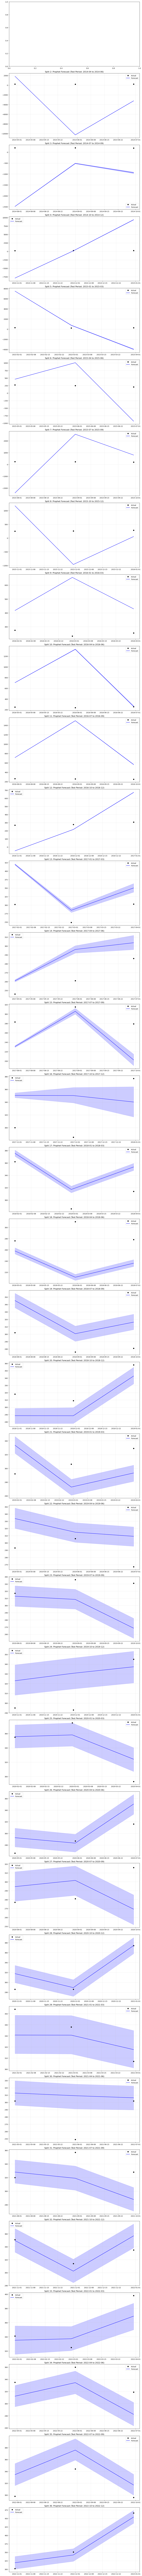


--- Average Performance Across All Splits ---
Mean Absolute Error (MAE): 632.83
Root Mean Squared Error (RMSE): 759.63
Mean Absolute Percentage Error (MAPE): 282.0%
Mean Absolute Scaled Error (MASE): 473.907
R² Score: -23094.5442


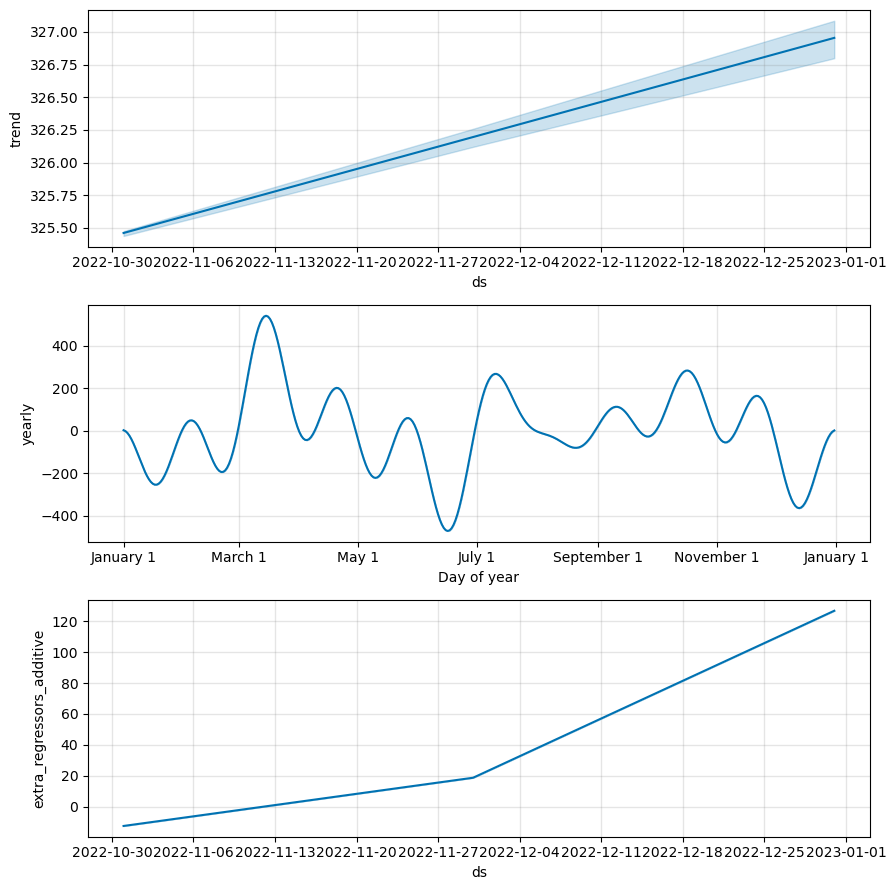


STEP 2: SELECTING BEST MODEL

Best model from validation:
Split 35
Training period: 2014-01 to 2022-09
Validation metrics:
  MAE: 12.70
  RMSE: 13.19
  MAPE: 3.6%
  MASE: 0.403
  R² Score: 0.9632

STEP 3: PREDICTING ON UNSEEN 2023 DATA

Model Performance on Unseen 2023 Data:
Mean Absolute Error (MAE): 16.14
Root Mean Squared Error (RMSE): 19.16
Mean Absolute Percentage Error (MAPE): 4.7%
Mean Absolute Scaled Error (MASE): 0.492
  ✅ Better than seasonal naive forecast!
Directional Accuracy: 72.7%
R² Score: 0.6615

Monthly Actual vs Forecasted Hip Fracture Counts:
Month        Actual     Forecast   Lower 95%    Upper 95%    Diff       Diff %    
------------------------------------------------------------------------------------------
2023-01      350.00     365.32     346.59       383.83       15.32      4.4       %
2023-02      304.00     287.65     268.50       306.73       -16.35     -5.4      %
2023-03      368.00     368.23     349.14       385.70       0.23       0.1       %
2023

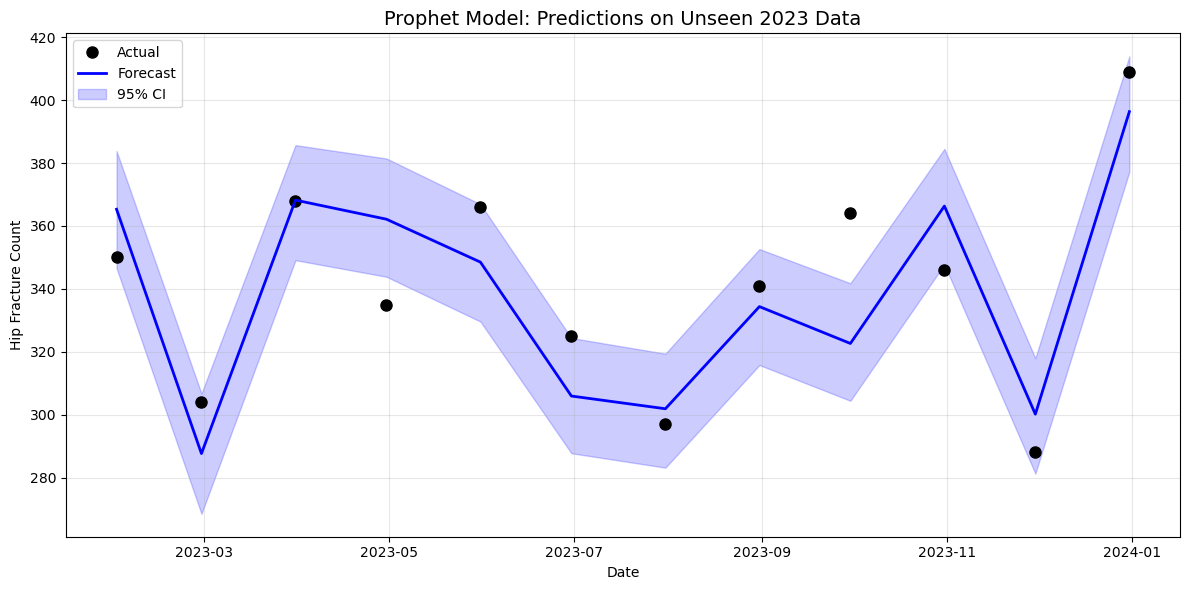

Saved components plot to: /home/paulharford/college/project/ul_project_Msc_AI/analysis/processed_data/visual_outputs/time_series//WEATHERED_time_series_components_2023.png


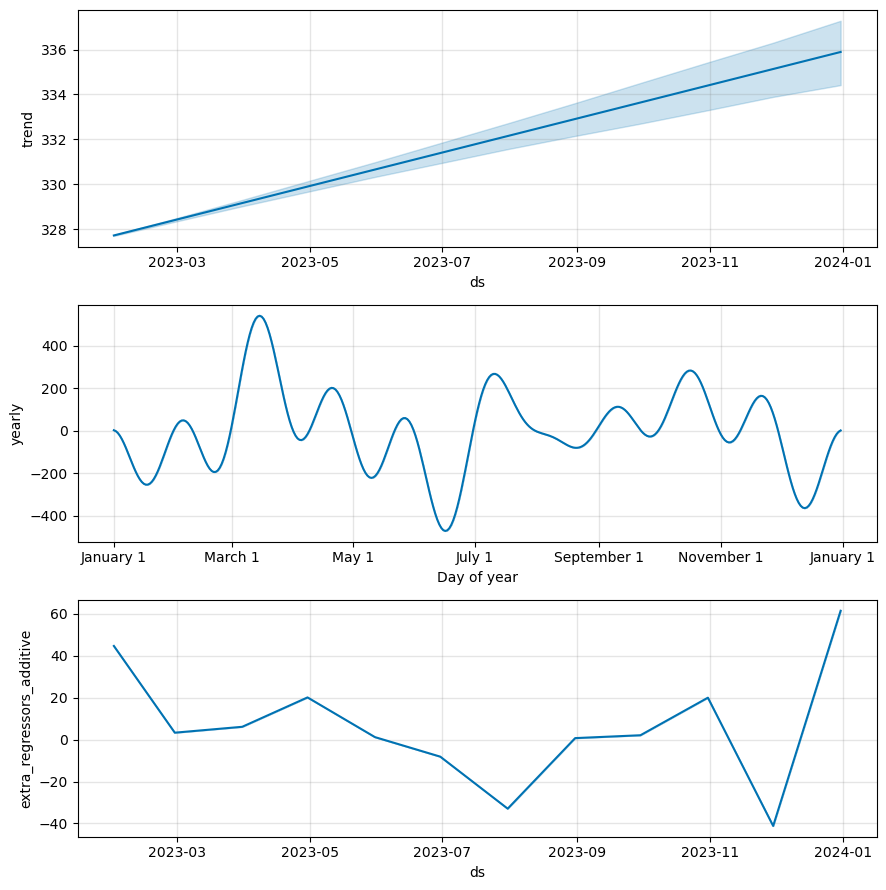

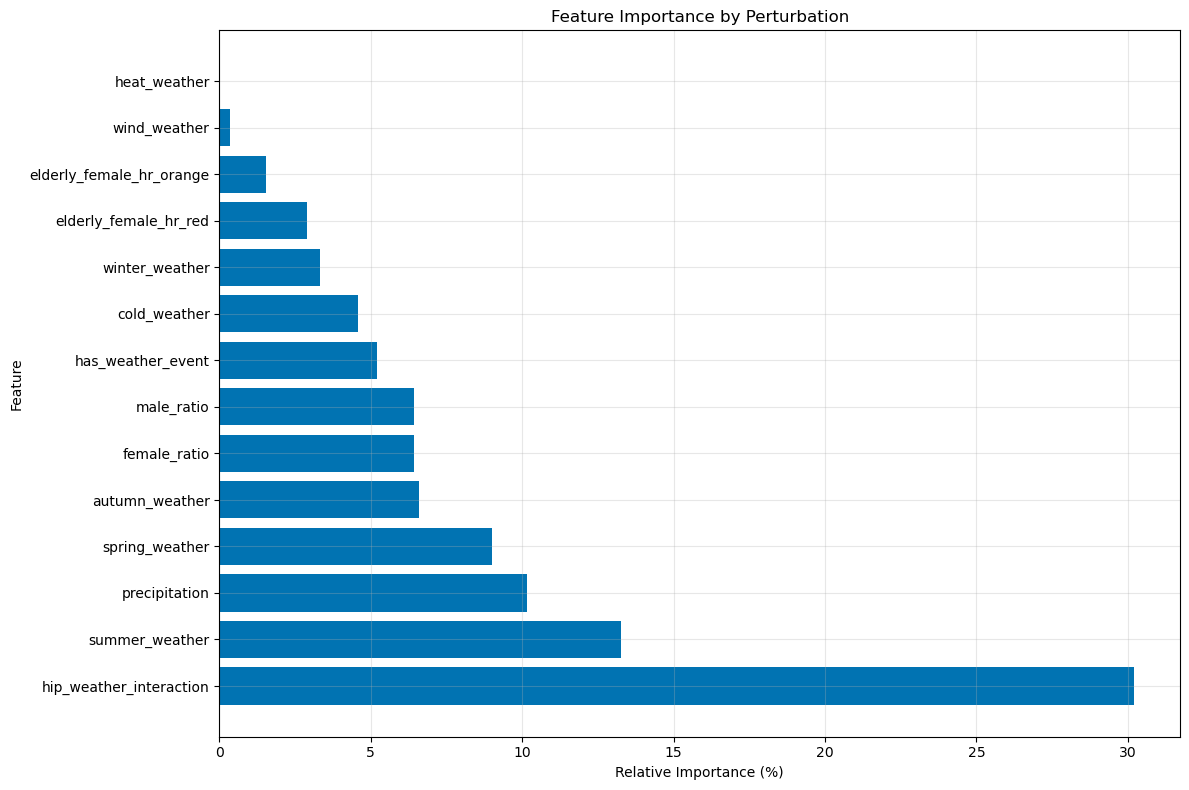

Saved feature importance plot to: /home/paulharford/college/project/ul_project_Msc_AI/analysis/processed_data/visual_outputs/time_series//WEATHERED_time_series_feature_importance_2023.png


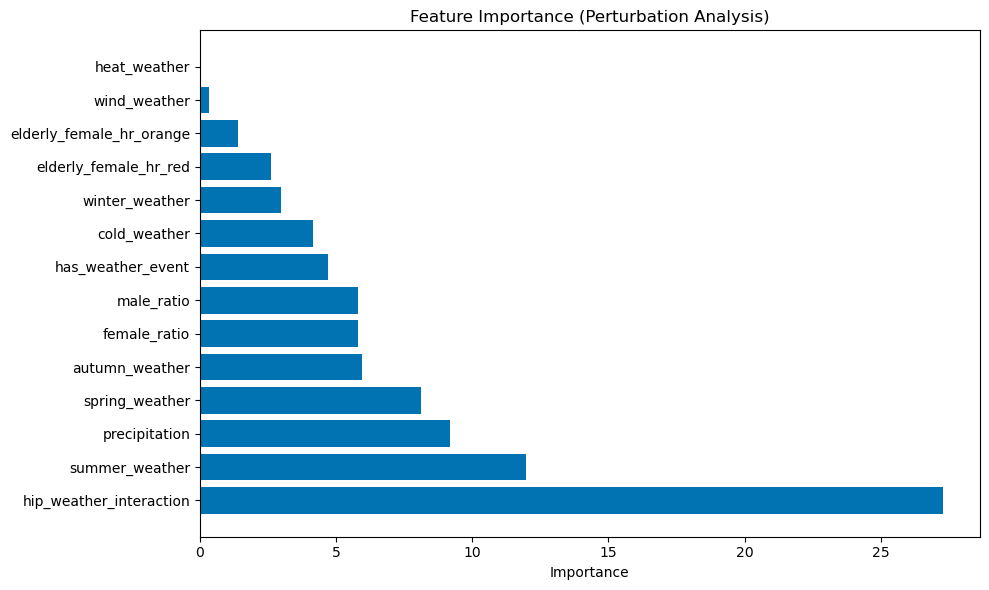

In [20]:
results = run_complete_prophet_pipeline(
    df_merged_train, 
    df_merged_unseen,
    n_splits=36,
    test_size_months=3
)

### Step 6.1: Check forecast results for bias 

In [21]:
def analyze_prediction_bias(forecast):
    """
    Analyze bias in predictions
    
    Parameters:
    -----------
    forecast : DataFrame
        Prophet forecast with 'y' (actual) and 'yhat' (predicted)
    """
    
    # Calculate errors
    errors = forecast['yhat'] - forecast['y']
    
    # Basic bias metrics
    mean_bias = errors.mean()
    median_bias = errors.median()
    
    # Percentage bias
    pct_bias = ((forecast['yhat'] - forecast['y']) / forecast['y'] * 100).mean()
    
    print("="*60)
    print("BIAS ANALYSIS")
    print("="*60)
    
    print(f"\nMean Bias: {mean_bias:.2f}")
    if mean_bias < 0:
        print(f"  → Model under-predicts by {abs(mean_bias):.2f} on average")
    else:
        print(f"  → Model over-predicts by {mean_bias:.2f} on average")
    
    print(f"\nMedian Bias: {median_bias:.2f}")
    print(f"Percentage Bias: {pct_bias:.1f}%")
    
    # Check if bias is statistically significant
    from scipy import stats
    t_stat, p_value = stats.ttest_1samp(errors, 0)
    print(f"\nStatistical Test for Bias:")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("  ✓ Bias is statistically significant")
    else:
        print("  ✓ Bias is not statistically significant")
    
    # Monthly bias pattern
    print("\nMonthly Bias Pattern:")
    print("-"*40)
    monthly_bias = pd.DataFrame({
        'Month': forecast['ds'].dt.strftime('%Y-%m'),
        'Actual': forecast['y'],
        'Predicted': forecast['yhat'],
        'Bias': errors,
        'Pct_Bias': (errors / forecast['y'] * 100)
    })
    print(monthly_bias.to_string(index=False))
    
    # Visualize bias
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Bias over time
    ax = axes[0, 0]
    ax.bar(forecast['ds'], errors, alpha=0.7, color='red', label='Prediction Bias')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.axhline(y=mean_bias, color='blue', linestyle='-', label=f'Mean Bias: {mean_bias:.1f}')
    ax.set_title('Prediction Bias Over Time')
    ax.set_ylabel('Bias (Predicted - Actual)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Histogram of errors
    ax = axes[0, 1]
    ax.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', label='Zero bias')
    ax.axvline(x=mean_bias, color='green', linestyle='-', label=f'Mean: {mean_bias:.1f}')
    ax.set_title('Distribution of Prediction Errors')
    ax.set_xlabel('Bias')
    ax.set_ylabel('Frequency')
    ax.legend()
    
    # 3. Actual vs Predicted with bias line
    ax = axes[1, 0]
    ax.scatter(forecast['y'], forecast['yhat'], alpha=0.6)
    min_val = min(forecast['y'].min(), forecast['yhat'].min())
    max_val = max(forecast['y'].max(), forecast['yhat'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
    ax.plot([min_val, max_val], [min_val + mean_bias, max_val + mean_bias], 'g-', 
            label=f'Actual bias: {mean_bias:.1f}')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title('Actual vs Predicted Values')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Bias by month of year
    ax = axes[1, 1]
    monthly_bias_summary = pd.DataFrame({
        'month': forecast['ds'].dt.month,
        'bias': errors
    }).groupby('month')['bias'].mean()
    
    ax.bar(monthly_bias_summary.index, monthly_bias_summary.values, alpha=0.7)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Bias')
    ax.set_title('Seasonal Bias Pattern')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return mean_bias, monthly_bias

BIAS ANALYSIS

Mean Bias: -2.78
  → Model under-predicts by 2.78 on average

Median Bias: -3.20
Percentage Bias: -0.7%

Statistical Test for Bias:
  t-statistic: -0.486
  p-value: 0.6363
  ✓ Bias is not statistically significant

Monthly Bias Pattern:
----------------------------------------
  Month  Actual  Predicted       Bias   Pct_Bias
2023-01   350.0 365.321548  15.321548   4.377585
2023-02   304.0 287.654367 -16.345633  -5.376853
2023-03   368.0 368.229603   0.229603   0.062392
2023-04   335.0 362.161580  27.161580   8.107934
2023-05   366.0 348.514439 -17.485561  -4.777476
2023-06   325.0 305.949846 -19.050154  -5.861586
2023-07   297.0 301.903648   4.903648   1.651060
2023-08   341.0 334.378723  -6.621277  -1.941724
2023-09   364.0 322.658252 -41.341748 -11.357623
2023-10   346.0 366.334702  20.334702   5.877081
2023-11   288.0 300.179835  12.179835   4.229109
2023-12   409.0 396.347983 -12.652017  -3.093403


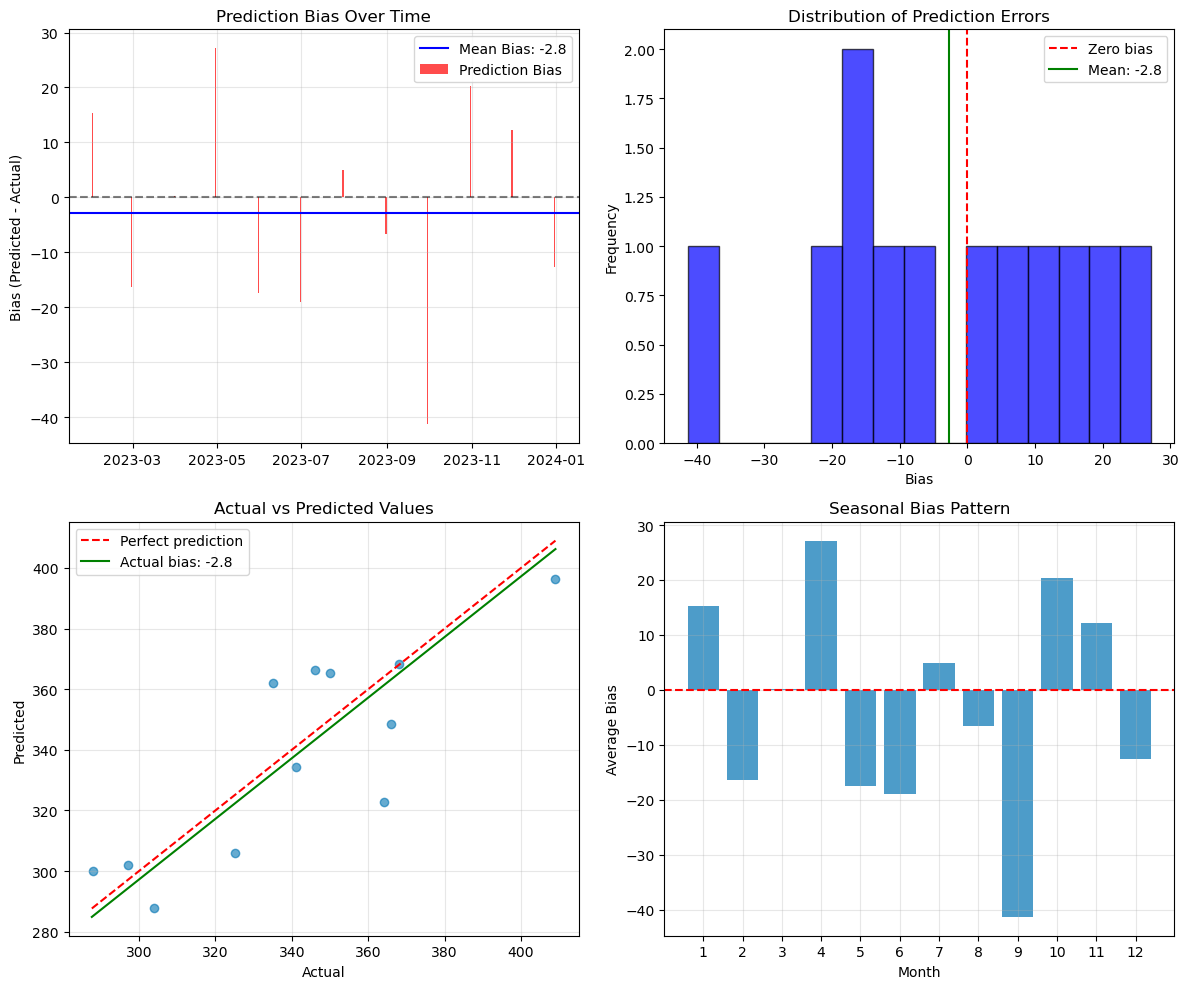

In [22]:
forecast_2023 = results['forecast']
mean_bias_2023, monthly_bias_2023 = analyze_prediction_bias(forecast_2023)

In [23]:
forecast_2023.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,autumn_weather,...,winter_weather_lower,winter_weather_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2023-01-31,327.713737,346.585915,383.830861,327.690769,327.732662,37.607811,37.607811,37.607811,1.616973,...,7.086004,7.086004,-7.102893,-7.102893,-7.102893,0.0,0.0,0.0,365.321548,350.0
1,2023-02-28,328.399188,268.500134,306.728755,328.324073,328.463453,-40.744821,-40.744821,-40.744821,1.616973,...,-1.784521,-1.784521,-44.071087,-44.071087,-44.071087,0.0,0.0,0.0,287.654367,304.0
2,2023-03-31,329.158081,349.135521,385.700125,329.014583,329.297807,39.071522,39.071522,39.071522,1.616973,...,-1.784521,-1.784521,32.938588,32.938588,32.938588,0.0,0.0,0.0,368.229603,368.0
3,2023-04-30,329.892493,343.863276,381.466498,329.658944,330.127287,32.269087,32.269087,32.269087,1.616973,...,-1.784521,-1.784521,12.119202,12.119202,12.119202,0.0,0.0,0.0,362.161580,335.0
4,2023-05-31,330.651386,329.615056,366.936476,330.321971,330.978570,17.863054,17.863054,17.863054,1.616973,...,-1.784521,-1.784521,16.659054,16.659054,16.659054,0.0,0.0,0.0,348.514439,366.0
